<a href="https://colab.research.google.com/github/FelixSchmid/Reinforcement_Learning/blob/master/Deep_Q_Network_CartPole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DQN on the CartPole problem

### The CartPole problem

As the image below shows, the goal of the agent is to balance a verticle rod on the top of the car. This position is unstable and that is the main reason for the difficulty.

<img src="https://drive.google.com/uc?export=download&id=1wiFksyB3-mcirfdZEvrT2DPD7SBEjye2" >

The problem is solved if the average of the agent's scores is greater than 195 gathered in 100 episodes.
The agent receives reward 1 in each timestep until the psoition of the rod is correct (not inclined too far away from the vertical position).
The length of one episode is 200 time steps. Therefore the possible maximum score is 200.

The state is low dimensional and cosists of:
* position 
* velocity
* angle 
* angular velocity

Further details can be found on OpenAI gym's webpage: [Leader Board](https://github.com/openai/gym/wiki/CartPole-v0)

In [0]:
%matplotlib inline
%tensorflow_version 1.x
import matplotlib.pyplot as plt
import gym 
from gym.wrappers import Monitor
import numpy as np
import random
from enum import Enum
from skimage import transform as trf
from keras.models import Sequential # Keras: highlevel API above dnn libraries (tendorflow, cntr, theano)
from keras.layers import Dense, Convolution2D, Flatten
from keras.optimizers import Adam, SGD, RMSprop

TensorFlow 1.x selected.


Using TensorFlow backend.


In [0]:
class Optimizer(Enum): # Enum, Makes easier to try different optimizers
    ADAM = 1
    RMSPROP = 2
    SGD = 3

In [0]:
# The implementation of DQN.
class Dqn:
    
    def __init__(self, params):         
        self.env = None                       # The environment where the RL agent will learn.
        self.buffer_size = params.buf_size    # The maximum size of the experience replay.
        self.batch_size = params.batch        # Batch size during training.
        self.epoch = params.epoch             # For one training cycle, the number epoch on a batch.
        self.max_episode = params.max_ep      # The number of episodes for training.
        self.eps0 = params.eps                # The starting value of epsilon in the epsilon-greedy policy.
        self.gamma = params.gamma             # Discounting factor.
        self.C = params.C                     # Frequency of synchronizing the frozen network.
        self.train_freq = params.train_freq   # Update frequency for the not frozen network.
        self.eval_freq = params.eval_freq     # Evaluation frequency.
        self.net = params.net                 # The description of the network. List of tuples. A tuple: (number of units, activation)
        self.lr = params.lr                   # learning rate
        self.opt = params.opt                 # Optimizer.

        self.q_cont, self.q_frzn = None, None # two networks for training: continuously updated and frozen

        self.buffer = []  # experience replay
        
        self.env = gym.make('CartPole-v0')
        self.env.reset()
        self.q_cont, self.q_frzn = self._init_models()
    
    # ------------------------------------------------------
    # functions for inicialization
    
    def _init_optimizer(self):

        optz = None
        if self.opt == Optimizer.ADAM:
            optz = Adam(self.lr)
        elif self.opt == Optimizer.SGD:
            optz = SGD(self.lr)
        elif self.opt == Optimizer.RMSPROP:
            optz = RMSprop(self.lr)

        return optz

    # The network builds up from Dense layers (similar to the fully connected)
    def _init_models(self):
        
        def build(strc):
            # strc - list of tuples
            # each tuple contains: number of nodes in the dense layer, activation function name (e.g.: 'relu')
            q = Sequential() 
            q.add(Dense(strc[0][0], input_shape=(4,), activation=strc[0][1]))

            for i in range(1, len(strc)):
                q.add(Dense(strc[i][0], activation=strc[i][1]))

            optz = self._init_optimizer()
            q.compile(optimizer=optz, loss='mse')
            return q

        q_cont = build(self.net)  # continuously updated network (Q-function)
        q_frzn = build(self.net)  # frozen network

        q_cont.set_weights(q_frzn.get_weights())  # synchronization

        return q_cont, q_frzn

    def _init_buffer(self, number):
        # gathers 'number' pieces of experiences randomly
        exps = []
        obs, rw, done, _ = self.env.step(0)
        for _ in range(number):

            if done:
                obs = self.env.reset()

            action = self.env.action_space.sample()  # sampling random actions from the environment
            obs_next, rw, done, _ = self.env.step(action)  # taking the step and observe the results
            exps.append((obs, rw, action, done, obs_next))  # we append a new experience
            obs = obs_next

        self.append(exps) 
    
    def close(self):
        self.env.close()

    def train_function(self):
        
        # initializing experience replay with random experiences
        self._init_buffer(self.batch_size)

        print("Initialization was finished.")
        print("Training was started.")

        ep_id = 1
        cntr = 0
        eval_permitted = True
        rtn = 0
        exps = []
        
        ep_ids = []
        returns = []

        eps = self.eps0
        self.env.reset()
        obs, _, done, _ = self.env.step(0)

        while ep_id < self.max_episode:

            cntr += 1

            if done:
                if ep_id % 10 == 0:
                    print('Episode Id: ' + str(ep_id) + ' Return during training: ' + str(rtn))
                rtn = 0
                ep_id += 1
                eval_permitted = True
                obs = self.env.reset() # when an episode ends (done = True) the environment is reseted
            
            action = self.select_action_epsilon(obs, eps)  
            obs_next, rw, done, _ = self.env.step(action)  
            rtn += rw
            
            if done:
                if rtn < 180:
                    rw = -1
                    obs_next *= 0.0
                    obs *= 0.0
                elif rtn >= 180:
                    rw = 100

            exps.append((obs, rw, action, done, obs_next))
            obs = obs_next

            if cntr % 128 == 0:
                self.append(exps)
                exps.clear()
            
            # training
            if  cntr % self.train_freq == 0:
                # sampling experiences from the replay then train q_cont with them
                x, y = self.sample(self.batch_size)
                self.q_cont.fit(x, y, epochs=self.epoch, batch_size=self.batch_size, verbose=0)
            
            # synchronizing the frozen network
            if cntr % self.C == 0:
                self.q_frzn.set_weights(self.q_cont.get_weights())

            # evaluating at the current stage of learning
            if ep_id % self.eval_freq == 0 and eval_permitted:
                r = self.evaluation()
                ep_ids.append(ep_id)
                returns.append(r)
                #print('EValuation at episode: ' + str(ep_id) + ' -> ' +  str(r))
                eval_permitted = False
                if r >= 185:
                    break
            
            # Decrasing the epsilon value for epsilon-greedy. Exploration -> exploitation
            eps = max(eps - 0.001, 0.01)

        print("Training was finished.")
        return ep_ids, returns

    def evaluation(self, video=False):
        
        orig_env = self.env
        if video:
            self.env = Monitor(orig_env, 'videos/cartpole', force=True)

        obs = self.env.reset()
        done = False
        rtn = 0
        ep_id = 0
        rtns = []

        while ep_id < 50:

            if done:
                rtns.append(rtn)
                rtn = 0
                ep_id += 1
                obs = self.env.reset()

            action = self.select_action_epsilon(obs, 0.01)
            obs, rw, done, _ = self.env.step(action)
            rtn += rw

        self.env = orig_env
        return np.mean(rtns)

    # ------------------------------------------------------
    # Functions for handling the experience replay

    def clear_buffer(self):
        self.buffer.clear()

    # The new experiences are added at the end of the buffer.
    # The too old experiences are deleted.
    def append(self, experiences):
        # experiences - list of experiences
        # check if appending the new set of experiences to the buffer has enough space 
        if len(self.buffer) + len(experiences) > self.buffer_size:
            # delete as many experiences as required 
            n = len(self.buffer) + len(experiences) - self.buffer_size
            del self.buffer[:n]

        #  appending the new experiences to the buffer
        self.buffer += experiences 

    def sample(self, number):
        exps = random.sample(self.buffer, number)    # experiences list
        obs = np.stack([x[0] for x in exps], axis=0) 
        rws = np.stack([x[1] for x in exps], axis=0) 
        acts = np.stack([x[2] for x in exps], axis=0) 
        dones = np.stack([x[3] for x in exps], axis=0) 
        next_obs = np.stack([x[4] for x in exps], axis=0) 

        # predict (forward execute) with q_cont on obs
        q_vals = self.q_cont.predict(obs, batch_size=number) 
        # predict with q_frzn on next_obs 
        fzn_q_vals = self.q_frzn.predict(next_obs, batch_size=number) 
        
        # The action function is represented by a network.
        # The input of this network is the state, 
        # the output is the set of action-values
        # corresponding to the actions.
        # So the number of outputs is equal with the number of actions.
        # In training we sample one transition at a time, therefore we have loss
        # for only one output (action) at a time.
        # But for training, we have to provide information for all of the outputs.

        sub_values = rws + self.gamma * (1 - dones) * np.max(fzn_q_vals, axis=1) 
        q_vals[list(range(number)), acts] = sub_values  
  
        x = obs.astype(dtype=np.float32)
        y = q_vals.astype(dtype=np.float32)

        return x, y

    # ------------------------------------------------------
    # Choosing an action

    # epsilon-greedy
    def select_action_epsilon(self, state, eps):  # state shape: (4) nunmpy array
        s = np.expand_dims(state, axis=0)
        max_idx = np.argmax(self.q_cont.predict(s, batch_size=1))
        if np.random.random() < 1 - eps:
            return max_idx
        return (max_idx + 1) % 2 # now we have only two actions

    # no epsilon-greedy
    def select_action(self, state):
        s = np.expand_dims(state, axis=0)
        return np.argmax(self.q_cont.predict(s, batch_size=1))

# 1. Run (default)

In [0]:
class Parameters:

    def __init__(self):
                                 # Default values
        self.buf_size = 5000     # 5000
        self.batch = 256         # 256
        self.epoch = 5           # 5
        self.max_ep = 500        # 500
        self.eps = 0.5           # 0.5
        self.gamma = 0.9         # 0.9
        self.C = 100             # 100
        self.train_freq = 1      # 1
        self.eval_freq = 10      # 10
        self.net = [(128, 'relu'), (128, 'relu'), (2, 'relu')] # [(128, 'relu'), (128, 'relu'), (2, 'relu')]
        self.lr = 0.0001         # 0.0001
        self.opt = Optimizer.ADAM # Optimizer.ADAM

Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 15.0
Episode Id: 20 Return during training: 11.0
Episode Id: 30 Return during training: 13.0
Episode Id: 40 Return during training: 11.0
Episode Id: 50 Return during training: 14.0
Episode Id: 60 Return during training: 37.0
Episode Id: 70 Return during training: 46.0
Episode Id: 80 Return during training: 44.0
Episode Id: 90 Return during training: 77.0
Episode Id: 100 Return during training: 71.0
Episode Id: 110 Return during training: 84.0
Episode Id: 120 Return during training: 58.0
Episode Id: 130 Return during training: 75.0
Episode Id: 140 Return during training: 75.0
Episode Id: 150 Return during training: 194.0
Episode Id: 160 Return during training: 107.0
Episode Id: 170 Return during training: 99.0
Episode Id: 180 Return during training: 41.0
Episode Id: 190 Return during training: 150.0
Training was finished.


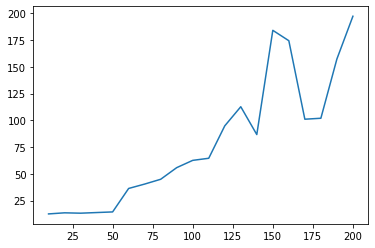

In [0]:
# Running the training and evaluation
pms = Parameters()
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
dqn.evaluation(video=False)
dqn.close()

# 2. Run (default)


In [0]:
class Parameters:

    def __init__(self):
                                 # Default values
        self.buf_size = 5000     # 5000
        self.batch = 256         # 256
        self.epoch = 5           # 5
        self.max_ep = 500        # 500
        self.eps = 0.5           # 0.5
        self.gamma = 0.9         # 0.9
        self.C = 100             # 100
        self.train_freq = 1      # 1
        self.eval_freq = 10      # 10
        self.net = [(128, 'relu'), (128, 'relu'), (2, 'relu')] # [(128, 'relu'), (128, 'relu'), (2, 'relu')]
        self.lr = 0.0001         # 0.0001
        self.opt = Optimizer.ADAM # Optimizer.ADAM

Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 15.0
Episode Id: 20 Return during training: 14.0
Episode Id: 30 Return during training: 12.0
Episode Id: 40 Return during training: 13.0
Episode Id: 50 Return during training: 13.0
Episode Id: 60 Return during training: 13.0
Episode Id: 70 Return during training: 32.0
Episode Id: 80 Return during training: 31.0
Episode Id: 90 Return during training: 29.0
Episode Id: 100 Return during training: 61.0
Episode Id: 110 Return during training: 149.0
Episode Id: 120 Return during training: 153.0
Training was finished.


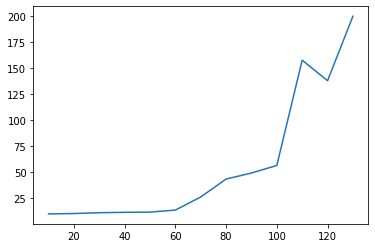

In [0]:
# Running the training and evaluation
pms = Parameters()
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
dqn.evaluation(video=False)
dqn.close()

# 3. Run (default)

In [0]:
class Parameters:

    def __init__(self):
                                 # Default values
        self.buf_size = 5000     # 5000
        self.batch = 256         # 256
        self.epoch = 5           # 5
        self.max_ep = 500         # 500
        self.eps = 0.5           # 0.5
        self.gamma = 0.9         # 0.9
        self.C = 100             # 100
        self.train_freq = 1      # 1
        self.eval_freq = 10      # 10
        self.net = [(128, 'relu'), (128, 'relu'), (2, 'relu')] # [(128, 'relu'), (128, 'relu'), (2, 'relu')]
        self.lr = 0.0001         # 0.0001
        self.opt = Optimizer.ADAM # Optimizer.ADAM

Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 9.0
Episode Id: 20 Return during training: 14.0
Episode Id: 30 Return during training: 15.0
Episode Id: 40 Return during training: 15.0
Episode Id: 50 Return during training: 28.0
Episode Id: 60 Return during training: 200.0
Training was finished.


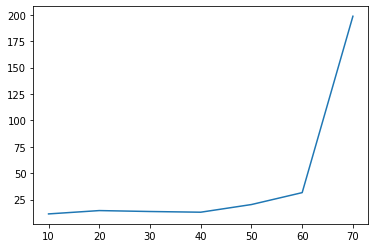

In [0]:
# Running the training and evaluation
pms = Parameters()
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
dqn.evaluation(video=False)
dqn.close()

# 4. Run (setting C to 1)

In [0]:
class Parameters:

    def __init__(self):
                                 # Default values
        self.buf_size = 5000     # 5000
        self.batch = 256         # 256
        self.epoch = 5           # 5
        self.max_ep = 500         # 500
        self.eps = 0.5           # 0.5
        self.gamma = 0.9         # 0.9
        self.C = 1             # 100
        self.train_freq = 1      # 1
        self.eval_freq = 10      # 10
        self.net = [(128, 'relu'), (128, 'relu'), (2, 'relu')] # [(128, 'relu'), (128, 'relu'), (2, 'relu')]
        self.lr = 0.0001         # 0.0001
        self.opt = Optimizer.ADAM # Optimizer.ADAM

Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 10.0
Episode Id: 20 Return during training: 11.0
Episode Id: 30 Return during training: 9.0
Episode Id: 40 Return during training: 9.0
Episode Id: 50 Return during training: 9.0
Episode Id: 60 Return during training: 9.0
Episode Id: 70 Return during training: 9.0
Episode Id: 80 Return during training: 9.0
Episode Id: 90 Return during training: 11.0
Episode Id: 100 Return during training: 10.0
Episode Id: 110 Return during training: 11.0
Episode Id: 120 Return during training: 10.0
Episode Id: 130 Return during training: 8.0
Episode Id: 140 Return during training: 10.0
Episode Id: 150 Return during training: 10.0
Episode Id: 160 Return during training: 9.0
Episode Id: 170 Return during training: 10.0
Episode Id: 180 Return during training: 9.0
Episode Id: 190 Return during training: 8.0
Episode Id: 200 Return during training: 10.0
Episode Id: 210 Return during training: 8.0
Episode Id: 220 Return d

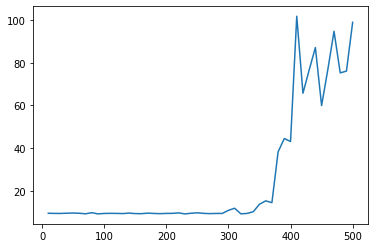

In [0]:
# Running the training and evaluation
pms = Parameters()
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
dqn.evaluation(video=False)
dqn.close()

# 5. Run (setting train frequency to 2)

In [0]:
class Parameters:

    def __init__(self):
                                 # Default values
        self.buf_size = 5000     # 5000
        self.batch = 256         # 256
        self.epoch = 5           # 5
        self.max_ep = 500         # 500
        self.eps = 0.5           # 0.5
        self.gamma = 0.9         # 0.9
        self.C = 100             # 100
        self.train_freq = 2      # 1
        self.eval_freq = 10      # 10
        self.net = [(128, 'relu'), (128, 'relu'), (2, 'relu')] # [(128, 'relu'), (128, 'relu'), (2, 'relu')]
        self.lr = 0.0001         # 0.0001
        self.opt = Optimizer.ADAM # Optimizer.ADAM

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Initialization was finished.
Training was started.

Episode Id: 10 Return during training: 17.0
Episode Id: 20 Return during training: 11.0
Episode Id: 30 Return during training: 10.0
Episode Id: 40 Return during training: 12.0
Episode Id: 50 Return during training: 12.0
Episode Id: 60 Return during training: 10.0
Episode Id: 70 Return during training: 12.0
Episode Id: 80 Return during training: 9.0
Episode Id: 90 Return during training: 12.0
Episode Id: 100 Return during training: 11.0
Episode Id: 110 Return during training: 9.0
Episode Id: 120 Return during training: 9.0
Episode Id: 130 Return during training: 10.0
Episode Id: 140 Return during training: 9.0
Episode Id: 150 Return during training: 10.0
Episode Id: 160 Return during training: 10.0
Episode Id: 170 Return during training: 9.0
Episode Id: 180 Return during training: 9.0
Episode Id: 190 Return during training: 10.0
Episode Id: 200 Return duri

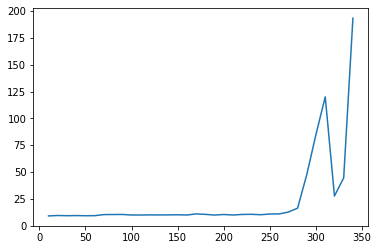

In [0]:
# Running the training and evaluation
pms = Parameters()
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
dqn.evaluation(video=False)
dqn.close()

# 6. Run (hidden layer size = 64)

In [0]:
class Parameters:

    def __init__(self):
                                 # Default values
        self.buf_size = 5000     # 5000
        self.batch = 256         # 256
        self.epoch = 5           # 5
        self.max_ep = 500         # 500
        self.eps = 0.5           # 0.5
        self.gamma = 0.9         # 0.9
        self.C = 100             # 100
        self.train_freq = 1      # 1
        self.eval_freq = 10      # 10
        self.net = [(64, 'relu'), (64, 'relu'), (2, 'relu')] # [(128, 'relu'), (128, 'relu'), (2, 'relu')]
        self.lr = 0.0001         # 0.0001
        self.opt = Optimizer.ADAM # Optimizer.ADAM

Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 17.0
Episode Id: 20 Return during training: 11.0
Episode Id: 30 Return during training: 10.0
Episode Id: 40 Return during training: 9.0
Episode Id: 50 Return during training: 10.0
Episode Id: 60 Return during training: 9.0
Episode Id: 70 Return during training: 12.0
Episode Id: 80 Return during training: 12.0
Episode Id: 90 Return during training: 9.0
Episode Id: 100 Return during training: 11.0
Episode Id: 110 Return during training: 13.0
Episode Id: 120 Return during training: 12.0
Episode Id: 130 Return during training: 11.0
Episode Id: 140 Return during training: 76.0
Episode Id: 150 Return during training: 105.0
Episode Id: 160 Return during training: 129.0
Episode Id: 170 Return during training: 117.0
Episode Id: 180 Return during training: 160.0
Episode Id: 190 Return during training: 125.0
Episode Id: 200 Return during training: 35.0
Episode Id: 210 Return during training: 133.0
Episode Id

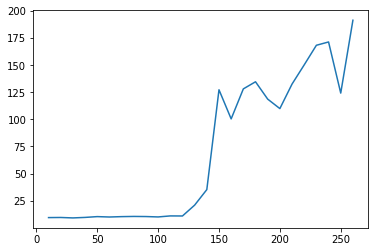

In [0]:
# Running the training and evaluation
pms = Parameters()
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
dqn.evaluation(video=False)
dqn.close()

# 7. Run (hidden layer size = 32)


In [0]:
class Parameters:

    def __init__(self):
                                 # Default values
        self.buf_size = 5000     # 5000
        self.batch = 256         # 256
        self.epoch = 5           # 5
        self.max_ep = 2000         # 500
        self.eps = 0.5           # 0.5
        self.gamma = 0.9         # 0.9
        self.C = 100             # 100
        self.train_freq = 1      # 1
        self.eval_freq = 10      # 10
        self.net = [(32, 'relu'), (32, 'relu'), (2, 'relu')] # [(128, 'relu'), (128, 'relu'), (2, 'relu')]
        self.lr = 0.0001         # 0.0001
        self.opt = Optimizer.ADAM # Optimizer.ADAM

Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 12.0
Episode Id: 20 Return during training: 13.0
Episode Id: 30 Return during training: 9.0
Episode Id: 40 Return during training: 10.0
Episode Id: 50 Return during training: 9.0
Episode Id: 60 Return during training: 10.0
Episode Id: 70 Return during training: 8.0
Episode Id: 80 Return during training: 9.0
Episode Id: 90 Return during training: 8.0
Episode Id: 100 Return during training: 9.0
Episode Id: 110 Return during training: 9.0
Episode Id: 120 Return during training: 10.0
Episode Id: 130 Return during training: 9.0
Episode Id: 140 Return during training: 10.0
Episode Id: 150 Return during training: 11.0
Episode Id: 160 Return during training: 9.0
Episode Id: 170 Return during training: 9.0
Episode Id: 180 Return during training: 10.0
Episode Id: 190 Return during training: 10.0
Episode Id: 200 Return during training: 9.0
Episode Id: 210 Return during training: 8.0
Episode Id: 220 Return du

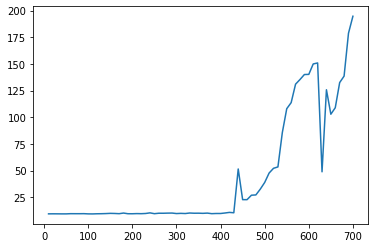

In [0]:
# Running the training and evaluation
pms = Parameters()
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
dqn.evaluation(video=False)
dqn.close()

 # 8. Run (hidden layer size = 16)

In [0]:
class Parameters:

    def __init__(self):
                                 # Default values
        self.buf_size = 5000     # 5000
        self.batch = 256         # 256
        self.epoch = 5           # 5
        self.max_ep = 3000         # 500
        self.eps = 0.5           # 0.5
        self.gamma = 0.9         # 0.9
        self.C = 100             # 100
        self.train_freq = 1      # 1
        self.eval_freq = 10      # 10
        self.net = [(16, 'relu'), (16, 'relu'), (2, 'relu')] # [(128, 'relu'), (128, 'relu'), (2, 'relu')]
        self.lr = 0.0001         # 0.0001
        self.opt = Optimizer.ADAM # Optimizer.ADAM

Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 11.0
Episode Id: 20 Return during training: 15.0
Episode Id: 30 Return during training: 10.0
Episode Id: 40 Return during training: 10.0
Episode Id: 50 Return during training: 10.0
Episode Id: 60 Return during training: 9.0
Episode Id: 70 Return during training: 9.0
Episode Id: 80 Return during training: 9.0
Episode Id: 90 Return during training: 10.0
Episode Id: 100 Return during training: 12.0
Episode Id: 110 Return during training: 11.0
Episode Id: 120 Return during training: 9.0
Episode Id: 130 Return during training: 9.0
Episode Id: 140 Return during training: 11.0
Episode Id: 150 Return during training: 11.0
Episode Id: 160 Return during training: 13.0
Episode Id: 170 Return during training: 9.0
Episode Id: 180 Return during training: 9.0
Episode Id: 190 Return during training: 11.0
Episode Id: 200 Return during training: 9.0
Episode Id: 210 Return during training: 9.0
Episode Id: 220 Return

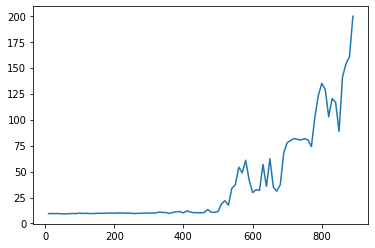

In [0]:
# Running the training and evaluation
pms = Parameters()
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
dqn.evaluation(video=False)
dqn.close()

 # 9. Run (hidden layer size = 8)

In [0]:
class Parameters:

    def __init__(self):
                                 # Default values
        self.buf_size = 5000     # 5000
        self.batch = 256         # 256
        self.epoch = 5           # 5
        self.max_ep = 3000         # 500
        self.eps = 0.5           # 0.5
        self.gamma = 0.9         # 0.9
        self.C = 100             # 100
        self.train_freq = 1      # 1
        self.eval_freq = 10      # 10
        self.net = [(8, 'relu'), (8, 'relu'), (2, 'relu')] # [(128, 'relu'), (128, 'relu'), (2, 'relu')]
        self.lr = 0.0001         # 0.0001
        self.opt = Optimizer.ADAM # Optimizer.ADAM

Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 11.0
Episode Id: 20 Return during training: 10.0
Episode Id: 30 Return during training: 10.0
Episode Id: 40 Return during training: 10.0
Episode Id: 50 Return during training: 10.0
Episode Id: 60 Return during training: 9.0
Episode Id: 70 Return during training: 8.0
Episode Id: 80 Return during training: 9.0
Episode Id: 90 Return during training: 9.0
Episode Id: 100 Return during training: 9.0
Episode Id: 110 Return during training: 8.0
Episode Id: 120 Return during training: 9.0
Episode Id: 130 Return during training: 11.0
Episode Id: 140 Return during training: 10.0
Episode Id: 150 Return during training: 10.0
Episode Id: 160 Return during training: 9.0
Episode Id: 170 Return during training: 12.0
Episode Id: 180 Return during training: 12.0
Episode Id: 190 Return during training: 11.0
Episode Id: 200 Return during training: 9.0
Episode Id: 210 Return during training: 9.0
Episode Id: 220 Return 

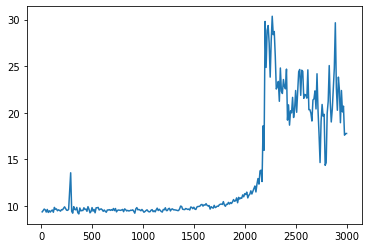

In [0]:
# Running the training and evaluation
pms = Parameters()
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
dqn.evaluation(video=False)
dqn.close()

 # 10. Run (decreasing buffer size to 500)

In [0]:
class Parameters:

    def __init__(self):
                                 # Default values
        self.buf_size = 500      # 5000
        self.batch = 256         # 256
        self.epoch = 5           # 5
        self.max_ep = 500         # 500
        self.eps = 0.5           # 0.5
        self.gamma = 0.9         # 0.9
        self.C = 100             # 100
        self.train_freq = 1      # 1
        self.eval_freq = 10      # 10
        self.net = [(128, 'relu'), (128, 'relu'), (2, 'relu')] # [(128, 'relu'), (128, 'relu'), (2, 'relu')]
        self.lr = 0.0001         # 0.0001
        self.opt = Optimizer.ADAM # Optimizer.ADAM

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Initialization was finished.
Training was started.

Episode Id: 10 Return during training: 20.0
Episode Id: 20 Return during training: 15.0
Episode Id: 30 Return during training: 13.0
Episode Id: 40 Return during training: 11.0
Episode Id: 50 Return during training: 10.0
Episode Id: 60 Return during training: 23.0
Episode Id: 70 Return during training: 19.0
Episode Id: 80 Return during training: 18.0
Episode Id: 90 Return during training: 16.0
Episode Id: 100 Return during training: 14.0
Episode Id: 110 Return during training: 19.0
Episode Id: 120 Return during training: 25.0
Episode Id: 130 Return during training: 28.0
Episode Id: 140 Return during training: 34.0
Episode Id: 150 Return during training: 10.0
Episode Id: 160 Return during training: 12.0
Episode Id: 170 Return during training: 9.0
Episode Id: 180 Return during training: 11.0
Episode Id: 190 Return during training: 11.0
Episode Id: 200 Return

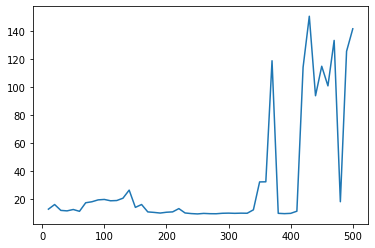

In [0]:
# Running the training and evaluation
pms = Parameters()
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
dqn.evaluation(video=False)
dqn.close()

 # 11. Run (increasing buffer size to 50000)

In [0]:
class Parameters:

    def __init__(self):
                                 # Default values
        self.buf_size = 50000    # 5000
        self.batch = 256         # 256
        self.epoch = 5           # 5
        self.max_ep = 500         # 500
        self.eps = 0.5           # 0.5
        self.gamma = 0.9         # 0.9
        self.C = 100             # 100
        self.train_freq = 1      # 1
        self.eval_freq = 10      # 10
        self.net = [(128, 'relu'), (128, 'relu'), (2, 'relu')] # [(128, 'relu'), (128, 'relu'), (2, 'relu')]
        self.lr = 0.0001         # 0.0001
        self.opt = Optimizer.ADAM # Optimizer.ADAM

Initialization was finished.
Training was started.
Episode Id: 10 Return during training: 14.0
Episode Id: 20 Return during training: 10.0
Episode Id: 30 Return during training: 9.0
Episode Id: 40 Return during training: 13.0
Episode Id: 50 Return during training: 16.0
Episode Id: 60 Return during training: 29.0
Episode Id: 70 Return during training: 75.0
Episode Id: 80 Return during training: 75.0
Episode Id: 90 Return during training: 79.0
Training was finished.


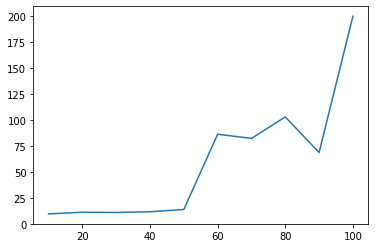

In [0]:
# Running the training and evaluation
pms = Parameters()
dqn = Dqn(pms)
ep_ids, returns = dqn.train_function()
plt.plot(ep_ids, returns)
dqn.evaluation(video=False)
dqn.close()

# 12. Summary

With default parameters the DQN algorithm seems to converge most times. However, the number of epsiodes until convergergence varies and it does not necessarily learns continuously. 

When playing around with the hyperparameters, I focused on the hyperparameters, which are specific to reinforcement learning and which I did not encounter before such as the size of the experience replay and the frequency of synchronizing the frozen network. I was also interested in how far I could decrease the overall layer sizes / compress the approximation of the q-learning table.

One observation regarding the layer sizes is that the smaller the neural network gets, the more episodes for training are needed to win the game. When using two hidden layers with 16 neurons each, the algorithm was still able to win the game after about 900 episodes. However, using 8 neurons per layer seems to small to win the game. Here, the return starts to fluctuate around 20 with no upward trend. So, I belive even with increased episodes (3000 were tested) the algorithm would not converge. 

When setting the frequency of syncronication of the frozen network to 1, the algorithm does not converge anymore (500 episodes were tested). Also, the reward fluctuates more. This is, of course, not surprising as the idea of the delayed update of the frozen network is to stabilize the training process.

Decreasing the buffer size/experience replay from 5000 to 500, did harm the algorithm and it could not converve within 500 episodes. As old experience are deleted when new experiences are added that could mean that the old experience are still valuable for winning. Also, the shorter the memory, the more the experiences correllate with each other. On the other hand, when we increase the buffer size from 5000 to 50000, there are no noticeable changes in performance. Some runs with default parameters performed better, some worse.

As said, I focused on specific DQN hyperparameters. Batch size and the number of epochs are important parameters, too -- especially to increase the computational performance of the algorithm. Also, the learning rate is important and I think with optimizing the learning rate, we could make the algorithm more stable. If I had more time, I would also run some variations of gamma. The higher gamma is set, the higher future rewards are weighted and vice versa. It would be interesting to know the impact of that trade off.